##ГЛУБИННОЕ ОБУЧЕНИЕ НЕЙРОННЫХ СЕТЕЙ

ЛАБОРАТОРНАЯ РАБОТА №6

М21-181-1 Перевощикова Д.А.

Решение задачи распознования сигналов с использованием нейронных сетей

Цель работы – научится реализовывать нейронные сети глубокого обучения для
решения задачи распознавния сигналов с использованием фреймворка
Tensorflow.

Задачи:

1. Научиться загружать аудиофайлы во фреймворк TensorFlow/Keras и
изучить возможности реализации нейронных сетей для классификации
звуковых сигналов.

2. Получить навыки создания нейронных сетей глубокого обучения для
распознавания сигналов из стандартных наборов данных.

3. Исследовать обобщающую способность нейронных сетей в зависимости от
числа итераций обучения.

Для выполнения работы был создан набор данных mini_speech_rus, состоящий из 280 аудиофайлов WAV в с частотой дискретизации 16000 ГЦ. В набор входят 7 разных слов по 60 аудиофайлов в каждом.

Импортируем необходимые модули и зависимости

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [3]:
import zipfile
with zipfile.ZipFile("/content/mini_commans_rus.zip","r") as zip_ref:
    zip_ref.extractall("/content/mini_speech_rus")

Загрузка данных с локального окружения:

In [8]:
DATASET_PATH = '/content/mini_speech_rus/mini_commans_rus'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      '/content/mini_speech_rus/mini_commans_rus',
      extract = True,
      cache_dir='.', cache_subdir='data'
  )

Аудиоклипы набора данных хранятся в семи папках, соответствующих каждой голосовой команде: Слева, Справа, Квадрат, Да, Три, Нет, Стоп Создадим список команд:

In [5]:
commands = ['Слева','Справа','Квадрат','Да','Три','Нет','Стоп']
print('Commands:', commands)

Commands: ['Слева', 'Справа', 'Квадрат', 'Да', 'Три', 'Нет', 'Стоп']


Извлечем звуковые файлы в список filenames и перетасуем его:

In [9]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
 len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])


Number of total examples: 280
Number of examples per label: 30
Example file tensor: tf.Tensor(b'/content/mini_speech_rus/mini_commans_rus/\xc3\xa8\xce\xb1\xcf\x80\xc3\xba/Record_(online-voice-recorder.com)_(9).wav', shape=(), dtype=string)


Разделим данные из списка filenames на обучающие, проверочные и тестовые наборы:

In [10]:
train_files = filenames[:180]
val_files = filenames[180: 180 + 50]
test_files = filenames[-50:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 180
Validation set size 50
Test set size 50


Форма тензора, возвращаемого tf.audio.decode_wav, имеет вид [samples, channels], где channels равен 1 для моно или 2 для стерео. Мини-набор данных содержит только монозаписи

In [14]:
test_file = tf.io.read_file(DATASET_PATH+'/Да/Record_(online-voice-recorder.com) — копия (2).wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([20352, 1])

Определим функцию предобработки исходного набора данных в тензоры:

In [15]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)


Опредеим функцию для создания меток, используя родительские каталоги для каждого файла:

Разделим пути к файлам на tf.RaggedTensor

In [16]:
def get_label(file_path):
  parts = tf.strings.split(
    input=file_path, sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Определим вспомогательную функцию - get_waveform_and_label - которая объединяет все это. В качестве входных данных используется имя аудиофайла WAV/ Выходные данные представляют собой кортеж, содержащий тензоры аудио и меток, готовые к обучению с учителем.

In [17]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Получение меток и декодирования звуковых файлов

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)

Построим графики для некоторых звуковых сигналов

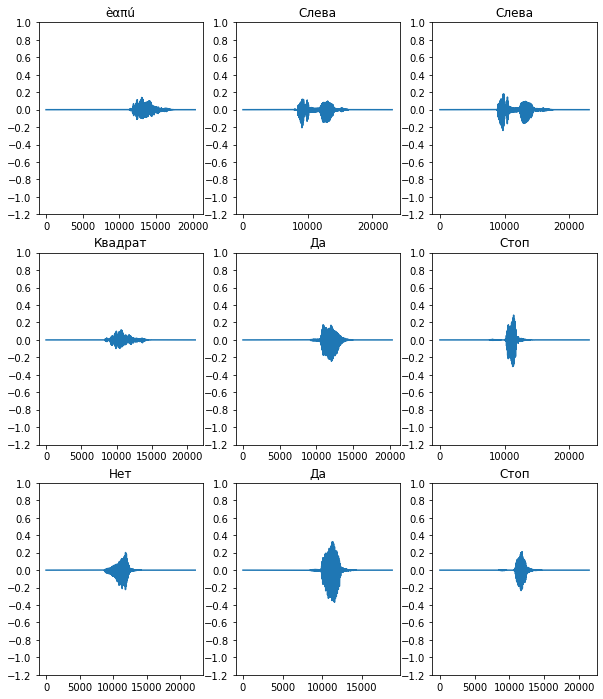

In [19]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()


Напишем функциб для преобразования звуковых файлов в спектограммы

In [20]:
def get_spectrogram(waveform):
# Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
  [16000] - tf.shape(waveform),
  dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
  equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


Отобразим метку, параметры звукового сигнала и вывод звука

In [21]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)
  
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: èαπú
Waveform shape: (20352,)
Spectrogram shape: (124, 129, 1)
Audio playback


Определим функцию для отображения спектограммы.

In [22]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Выведем сигнал и соответствующую ему спектограмму (частоты с течением времени)

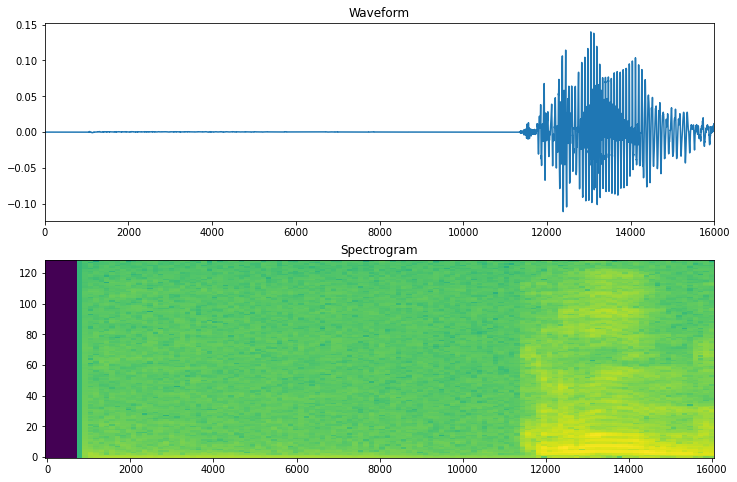

In [23]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Определим функцию преобразования сигнала в спектограмму и меток в целочисленное значение

In [24]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id


Сопоставим get_spectogram_and_label_id с элементами набора данных с помощью Dataset.map. Затем рассмотрим спектрограммы для различных примеров набора данных.

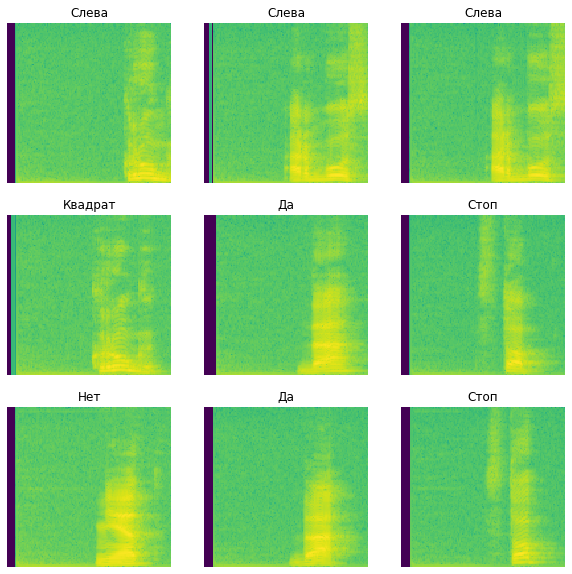

In [25]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()


##Построение и обучение модели

Повторим процедуру предварительной обработки обучающего набора для проверочного и тестового наборов

In [26]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
    map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
  return output_ds
  
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [27]:
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Для модели будем использовать простую сверточную нейронную сеть (CNN)

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(16, 16),
    # Normalize.
    norm_layer,
    layers.Conv2D(16, 3, activation='relu'),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),])

model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 16, 16, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 16, 16, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           

Настроим модель Keras с помощью оптимизатора Adam и кросс-энтропийной потери.

In [30]:
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'],
)


Обучение модели классификации сигналов

In [31]:
EPOCHS = 30
history = model.fit(train_ds,
validation_data=val_ds,
epochs=EPOCHS,
callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/30
12/12 [==============================] - 3s 132ms/step - loss: 1.9351 - accuracy: 0.2167 - val_loss: 1.8315 - val_accuracy: 0.3000
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.7467 - accuracy: 0.3778 - val_loss: 1.7939 - val_accuracy: 0.3000
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 1.6832 - accuracy: 0.3889 - val_loss: 1.7418 - val_accuracy: 0.3000
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 1.5748 - accuracy: 0.4000 - val_loss: 1.6513 - val_accuracy: 0.2800
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 1.5027 - accuracy: 0.4333 - val_loss: 1.5471 - val_accuracy: 0.3000
Epoch 6/30
12/12 [==============================] - 0s 12ms/step - loss: 1.3762 - accuracy: 0.4333 - val_loss: 1.4281 - val_accuracy: 0.3000
Epoch 7/30
12/12 [==============================] - 0s 13ms/step - loss: 1.3598 - accuracy: 0.4333 - val_loss: 1.3197 - val_accuracy: 0.3400
Epoch 8/30
1

Построим графики качества обучения модели

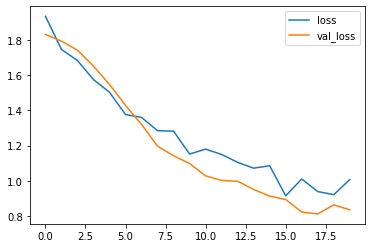

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

##Оценка производительности модели

Запустим модель на тестовом наборе и проверим производительность модели

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')


2/2 [==============================] - 0s 11ms/step
Test set accuracy: 62%


Используем матрицу ошибок классификации, для проверки качества классификации каждой из команд в тестовом наборе

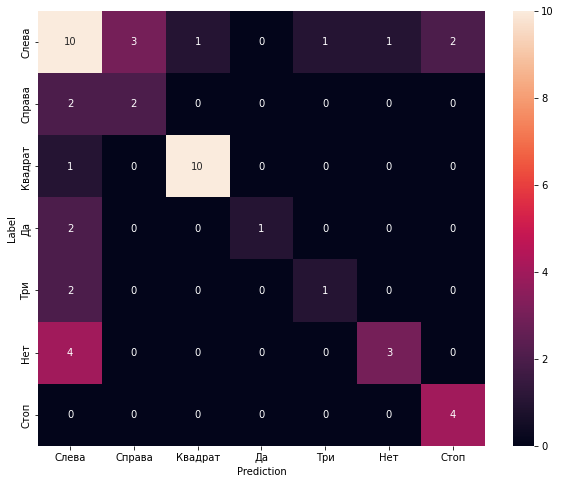

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
xticklabels=commands,
yticklabels=commands,
annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Проведем валидацию модели, используя входной аудиофайл, в котором кто-то говорит Круг.

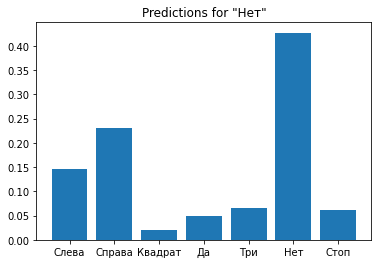

In [36]:
sample_file = '/content/mini_speech_rus/mini_commans_rus/Нет/Record_(online-voice-recorder.com) — копия (2).wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()
display.display(display.Audio(sample_file, rate=16000))

Как видно, модель предсказала значение круг с вероятностью больше 80%, что совпадает со значениями качества обучения модели